Source 1 : https://github.com/HOD101s/Face-Mask-Detection

Source 2 : https://github.com/mk-gurucharan/Face-Mask-Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil

from shutil import copyfile

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


Fetching Our Data.


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip "/content/drive/My Drive/PROJET S9/Classification/Datasets/our_dataset.zip" -d "/content/drive/My Drive/PROJET S9/Classification/Datasets/"

In [1]:
base = ''

DATAPATH = os.path.join(base,'datasets/our_dataset/')
MASKPATH = os.path.join(base,'datasets/our_dataset/mask/')
NOMASKPATH = os.path.join(base,'datasets/our_dataset/no_mask/')
TESTPATH = os.path.join(base,'datasets/our_dataset/testdata/')
TRAINPATH = os.path.join(base,'datasets/our_dataset/traindata/')

WEIGHTS_PATH = os.path.join(base,'weights/')
os.makedirs(WEIGHTS_PATH,exist_ok = True)
WEIGHTS_FILE = os.path.join(WEIGHTS_PATH,'weights_v2.h5')

BATCH_SIZE = 4
EPOCHS = 10
STEPS_PER_EPOCH = np.floor((2188 + 2400) / BATCH_SIZE ).astype('uint8')

print(STEPS_PER_EPOCH)

NameError: name 'os' is not defined

Visualizing our data

In [3]:
def view(pth):
    images = list()
    for img in random.sample(os.listdir(pth),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(pth,images[i])))
            i+=1

In [4]:
NumberMaskData = os.listdir(MASKPATH)
print(len(NumberMaskData))

2736


In [5]:
NumberNOMaskData = os.listdir(NOMASKPATH)
print(len(NumberNOMaskData))

3000


Analysing our Data

In [6]:
fig = go.Figure(
    data=[go.Pie(labels=['WITHMASK','WITHOUTMASK'], 
        values=[len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))])
    ])
fig.show()

Splitting Training Test

We have

NO MASK : 2,736 items

WITH MASK : 3,000 items

So now we split data into train test sets. We'll take around 2% data for testing purposes.

In [7]:
# os.mkdir(TESTPATH)
# os.mkdir(os.path.join(TESTPATH,'mask'))
# os.mkdir(os.path.join(TESTPATH,'no_mask'))

os.makedirs(TRAINPATH, exist_ok = True)
os.makedirs(os.path.join(TRAINPATH,'mask'), exist_ok = True)
os.makedirs(os.path.join(TRAINPATH,'no_mask'), exist_ok = True)

In [8]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE + unitData
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = SOURCE + unitData
        final_train_set = TRAINING + unitData
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = SOURCE + unitData
        final_test_set = TESTING + unitData
        copyfile(temp_test_set, final_test_set)

TRAIN_MASK_PATH = os.path.join(base,'datasets/our_dataset/traindata/mask/')
TRAIN_NOMASK_PATH = os.path.join(base,'datasets/our_dataset/traindata/no_mask/')
TEST_MASK_PATH = os.path.join(base,'datasets/our_dataset/testdata/mask/')
TEST_NOMASK_PATH = os.path.join(base,'datasets/our_dataset/testdata/no_mask/')

os.makedirs(TRAIN_MASK_PATH,exist_ok = True)
os.makedirs(TRAIN_NOMASK_PATH,exist_ok = True)
os.makedirs(TEST_MASK_PATH,exist_ok = True)
os.makedirs(TEST_NOMASK_PATH,exist_ok = True)


split_size = .8
split_data(MASKPATH, TRAIN_MASK_PATH, TEST_MASK_PATH, split_size)
split_data(NOMASKPATH, TRAIN_NOMASK_PATH, TEST_NOMASK_PATH, split_size)

In [9]:
print("The number of images with facemask in the training set:", len(os.listdir(TRAIN_MASK_PATH)))
print("The number of images with facemask in the test set:", len(os.listdir(TEST_MASK_PATH)))
print("The number of images without facemask in the training set:", len(os.listdir(TRAIN_NOMASK_PATH)))
print("The number of images without facemask in the test set:", len(os.listdir(TEST_NOMASK_PATH)))
print("The training set mask/no_mask sizes: (",len(os.listdir(TRAIN_MASK_PATH)),",",len(os.listdir(TRAIN_NOMASK_PATH)),")")
print("The test set mask/no_mask sizes: (",len(os.listdir(TEST_MASK_PATH)),",",len(os.listdir(TEST_NOMASK_PATH)),")")

The number of images with facemask in the training set: 2188
The number of images with facemask in the test set: 548
The number of images without facemask in the training set: 2400
The number of images without facemask in the test set: 600
The training set mask/no_mask sizes: ( 2188 , 2400 )
The test set mask/no_mask sizes: ( 548 , 600 )


In [15]:
# def getTest(pth):
#     dataSplit = int(np.ceil(len(os.listdir(pth))*0.02))
#     for img in os.listdir(pth)[-dataSplit:]:
#         shutil.move(os.path.join(pth,img), os.path.join('testdata'.join(pth.split('our_dataset')),img))
# getTest(MASKPATH)
# getTest(NOMASKPATH)

In [16]:
#len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))

In [17]:
#len(os.listdir(os.path.join(TESTPATH,'mask'))),len(os.listdir(os.path.join(TESTPATH,'mask')))

Preparing Data Input Pipelines

In [10]:
trainGen = ImageDataGenerator(rescale=1.0/255.,
                              rotation_range=40,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')

testGen = ImageDataGenerator(
    rescale= 1.0/255.,
)

train = trainGen.flow_from_directory(
    TRAINPATH, 
    target_size=(128, 128),
    classes=['mask','no_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='training'
)

validation = testGen.flow_from_directory(
    TESTPATH, 
    target_size=(128, 128),
    classes=['mask','no_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=False,
)

Found 4588 images belonging to 2 classes.
Found 1148 images belonging to 2 classes.


In [ ]:

# merci: https://yann-leguilly.gitlab.io/post/2019-10-09-tensorflow-tfdata/

# train_ds = tf.data.Dataset.from_generator(lambda: train,
#                      output_types=(tf.float32, tf.float32),
#                      output_shapes=([BATCH_SIZE, 128, 128, 3],
#                                     [BATCH_SIZE, 2])
#                      )

# valid_ds = tf.data.Dataset.from_generator(lambda: validation,
#                      output_types=(tf.float32, tf.float32),
#                      output_shapes=([1, 128, 128, 3],
#                                     [1, 2])
#                      )

Model Building

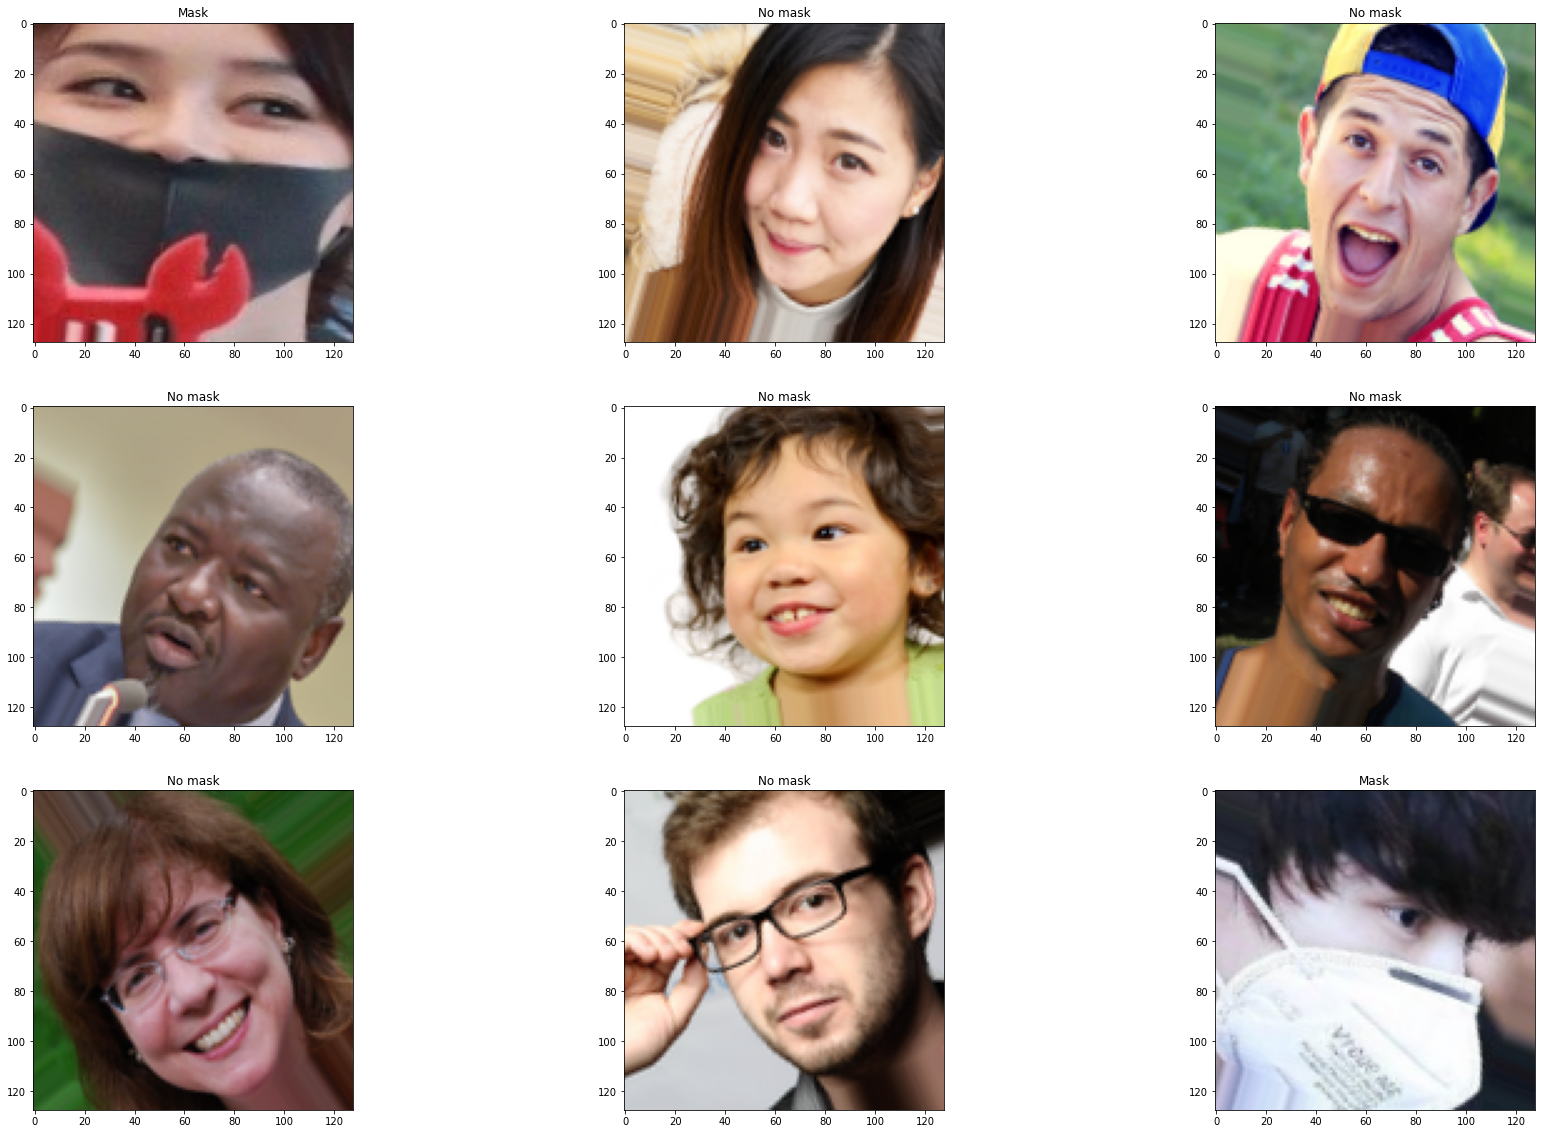

In [13]:
# imgs = list()
# classes = list()
# for i,c in train_ds.take(9):
#     imgs.append(np.array(i[0]))
#     classes.append(np.array(c[0]))

    
# fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
# i=0
# for row in range(3):
#     for col in range(3):
#         ax[row,col].imshow(imgs[i])
#         ax[row,col].title.set_text('Mask' if classes[i][0] == 1.0 else 'No mask')
#         i+=1


In [14]:
mob = MobileNetV2(
    input_shape = (128,128,3),
    include_top = False,
    weights = 'imagenet',
)
mob.trainable = False


In [15]:
model = Sequential()
model.add(mob)
model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 2,340,098
Trainable params: 82,114
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

In [ ]:
history = model.fit(
    train,
    epochs = EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_data = validation,
    callbacks = [checkpoint]
)

Train for 61 steps, validate for 1148 steps
Epoch 1/15


In [ ]:
# model.save_weights(WEIGHTS_FILE)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.savefig('')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()